# Imports

In [0]:
import pandas as pd 
import numpy as np
import requests
import io
import re
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import os
import json

In [46]:
drive.mount('/content/drive/')
logpath = 'drive/My Drive/mmath_cs/CHI_2020/typealike-study/data/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
logfns = os.listdir(logpath)

# these are columns that define a single trial
columns = ['Participant',            # participant id (P01, P02, ...)
           'Block',                  # upto 3
           'Sequence',               # upto 360
           'Trial',                  # upto 720
           'Target_Type',              # what condition this particpant did (typing, pointing, gesture)
           'Target_Name',                  # whats the specific label of this target
           'Start_Time',
           'End_Time',
           'First_Reaction_Time',
           'Trial_Completion_Time',  #time in ms
           'Error',                  # number of errors
            ]

# time format in the example log is like 2018/07/10-16:41:54.4902
# see https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior
# time_format = '%Y/%m/%d-%H:%M:%S.%f'
time_format = '%Y-%m-%d %H:%M:%S.%f'

In [0]:
# helper functions

# https://stackoverflow.com/questions/17060039/split-string-at-nth-occurrence-of-a-given-character
def splitn(string, spliton, n):
    """split 'string' on nth occurence of 'spliton'
    """
    groups = string.split(spliton)
    return spliton.join(groups[:n]), spliton.join(groups[n:])


def ms_delta(t):
    """convert timedelta t to milliseconds
    """
    return round(t.seconds * 1000 + t.microseconds / 1000)

In [58]:
data = open(logpath+'../mode_switching.csv', 'w')
data.write(','.join(columns) + '\n')

for logfn in logfns:

#     print(logfn)
    
    modeSwitch=False
    currentTaskFirstAttempt=0;
    previousTaskEndTime=0;
    nextTaskStart=False;
    prev_task=""
    
    log = open(logpath + logfn, 'r')
    
#     initalize a dictionary of values we'll write to the datafile
    d = {e:0 for e in columns}
    
    # initalize temporary values
    trial_start_time = 0

    # we'll go through line-by-line
    line_num = 0
    trial = 0
    trial_started = False
    first_reaction_recorded = False
    for row in log:
#         print(row)
        if row[0] == '#':             
            continue
        line_num += 1
        # split the line
        row_list = row.strip().split(',')
#         if row_list[1] == :
#           pass
#         if row_list[2]
        if trial_started and not first_reaction_recorded:
          if row_list[1] == 'I': 
            first_reaction_time = row_list[0]
            first_reaction_recorded = True
    
        if row_list[1] == 'E':
          row_split_list = splitn(row, ',', 3)
  #         experiment_block = (row_list[1], row_list[2])
          row_inner_dict = {}
          try:
              # parse the json event data
  #                 print("PARSIG JSON")
  #                 print(r[1])
              print(row_split_list)
              row_inner_dict = json.loads(row_split_list[1])
          except Exception as e:
              print('error parsing json event data on row{}: {}\n{}'.format(line_num, row_list[3], e))

          if row_list[2] == "experiment":
            d['Participant'] = row_inner_dict['participantid']

          if row_list[2] == "trial":
            print(row)

            if row_inner_dict["type"] == "start":
              trial_started = True
              first_reaction_recorded = False
              d['Start_Time'] = row_list[0]
  #             d['Participant'] = row_inner_dict['participantid']
              d['Target_Type'] = row_inner_dict["targetType"]
              d['Target_Name'] = row_inner_dict["label"]
              d['Block'] = row_inner_dict["blockNum"]
              d['Sequence'] = row_inner_dict["sequenceNum"]
              d['Trial'] = trial
              trial+=1
            elif row_inner_dict["type"] == "end":
              trial_started = False
              d['End_Time'] = row_list[0]
              d['Trial_Completion_Time'] = int(d['End_Time']) - int(d['Start_Time'])
              d['First_Reaction_Time'] = first_reaction_time if d['Target_Type'] != "shortcut" else row_list[0]
              d['Error'] = False if row_inner_dict["action"] == "hit" else True

              # save to log
              datarow = [d[k] for k in columns]
              datarow_csv = ','.join(str(i) for i in datarow)
    #                     print(datarow_csv)
              data.write(datarow_csv + '\n')
            
    
    break
data.close()        

('1567627933574,E,experiment', '{"type":"start","participantid":"participant_39","study":"two","datetime":"2019-09-04T20:12:13.540Z"}\n')
('1567627933625,E,block', '{"type":"start","num":"0","numBlocks":"10","datetime":"2019-09-04T20:12:13.625Z"}\n')
('1567627937845,E,sequence', '{"type":"start","blockNum":"0","num":"0","taskOrder":"0","datetime":"2019-09-04T20:12:17.845Z"}\n')
('1567627937845,E,trial', '{"type":"start","label":"click me","targetType":"click","sequenceNum":"0","blockNum":"0","num":"0","startX":"76","startY":"0","width":"100","height":"100","datetime":"2019-09-04T20:12:17.845Z"}\n')
1567627937845,E,trial,{"type":"start","label":"click me","targetType":"click","sequenceNum":"0","blockNum":"0","num":"0","startX":"76","startY":"0","width":"100","height":"100","datetime":"2019-09-04T20:12:17.845Z"}

('1567627939753,E,trial', '{"type":"end","label":"click me","action":"hit","currScore":"0","targetType":"click","num":"0","sequenceNum":"0","blockNum":"0","datetime":"2019-09-04

In [12]:
logfns

['participant_39_experiment_2019-09-04-16-12-13.txt',
 'participant_41_experiment_2019-09-04-19-05-57.txt',
 'participant_35_experiment_2019-09-03-15-57-34.txt',
 'participant_36_experiment_2019-09-03-16-58-26.txt',
 'participant_37_experiment_2019-09-03-23-06-46.txt',
 'participant_33_experiment_2019-09-02-15-48-35.txt',
 'participant_38_experiment_2019-09-04-14-54-31.txt',
 'participant_40_experiment_2019-09-04-18-12-17.txt',
 'participant_34_experiment_2019-09-02-17-51-29.txt',
 'participant_42_experiment_2019-09-05-14-19-57.txt',
 'participant_49_experiment_2019-09-06-20-00-11.txt',
 'participant_45_experiment_2019-09-05-18-50-20.txt',
 'participant_47_experiment_2019-09-06-16-47-27.txt',
 'participant_43_experiment_2019-09-05-16-01-45.txt',
 'participant_46_experiment_2019-09-05-22-37-21.txt',
 'participant_44_experiment_2019-09-05-17-25-07.txt',
 'participant_48_experiment_2019-09-06-18-51-31.txt']

# Load Data

In [0]:
BASE_URL = "https://docs.google.com/spreadsheets/d/1VpLXByvbTfbgupDNWcUaBxdk72cW9FRExs0AgRVaF1g/export?format=csv&"
URL_PARTICIPANTS = BASE_URL+"gid=611260429"
URL_POSTURES = BASE_URL+"gid=961690077"
content_participants = requests.get(URL_PARTICIPANTS, verify=False).content
content_postures = requests.get(URL_POSTURES, verify=False).content
df_participants = pd.read_csv(io.StringIO(content_participants.decode('utf-8'))) 
df_postures = pd.read_csv(io.StringIO(content_postures.decode('utf-8'))) 
plt.rcParams['figure.dpi'] = 100

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
df_participants.head(1)

,ParticipantID,Age,Gender,DominantHand,AvgTimeSpent,WordsPerMinute,WordCount,Errors,TimeTakenS,TimeTakenM,MeanError,totalwords,time,sec
0,participant_1,27.0,Male,Right,10.0,57.0,89.0,15.0,94.0,1.561404,9.606742,104.0,1.561404,93.684211


In [0]:
df_postures.head(1)

,ParticipantID,Comfort_Below_Left_Fist_0,Preference_Below_Left_Fist_0,Comfort_Below_Right_Fist_0,Preference_Below_Right_Fist_0,Comfort_Below_Left_Fist_90,Preference_Below_Left_Fist_90,Comfort_Below_Right_Fist_90,Preference_Below_Right_Fist_90,Comfort_Below_Left_Fist_180,Preference_Below_Left_Fist_180,Comfort_Below_Right_Fist_180,Preference_Below_Right_Fist_180,Comfort_Below_Left_Palm_0,Preference_Below_Left_Palm_0,Comfort_Below_Right_Palm_0,Preference_Below_Right_Palm_0,Comfort_Below_Left_Palm_90,Preference_Below_Left_Palm_90,Comfort_Below_Right_Palm_90,Preference_Below_Right_Palm_90,Comfort_Below_Left_Palm_180,Preference_Below_Left_Palm_180,Comfort_Below_Right_Palm_180,Preference_Below_Right_Palm_180,Comfort_On_Left_Fist_0,Preference_On_Left_Fist_0,Comfort_On_Right_Fist_0,Preference_On_Right_Fist_0,Comfort_On_Left_Fist_90,Preference_On_Left_Fist_90,Comfort_On_Right_Fist_90,Preference_On_Right_Fist_90,Comfort_On_Left_Fist_180,Preference_On_Left_Fist_180,Comfort_On_Right_Fist_180,Preference_On_Right_Fist_180,Comfort_On_Left_Palm_0,Preference_On_Left_Palm_0,Comfort_On_Right_Palm_0,Preference_On_Right_Palm_0,Comfort_On_Left_Palm_90,Preference_On_Left_Palm_90,Comfort_On_Right_Palm_90,Preference_On_Right_Palm_90,Comfort_On_Left_Palm_180,Preference_On_Left_Palm_180,Comfort_On_Right_Palm_180,Preference_On_Right_Palm_180,Comfort_Beside_Left_Fist_0,Preference_Beside_Left_Fist_0,Comfort_Beside_Right_Fist_0,Preference_Beside_Right_Fist_0,Comfort_Beside_Left_Fist_90,Preference_Beside_Left_Fist_90,Comfort_Beside_Right_Fist_90,Preference_Beside_Right_Fist_90,Comfort_Beside_Left_Fist_180,Preference_Beside_Left_Fist_180,Comfort_Beside_Right_Fist_180,Preference_Beside_Right_Fist_180,Comfort_Beside_Left_Palm_0,Preference_Beside_Left_Palm_0,Comfort_Beside_Right_Palm_0,Preference_Beside_Right_Palm_0,Comfort_Beside_Left_Palm_90,Preference_Beside_Left_Palm_90,Comfort_Beside_Right_Palm_90,Preference_Beside_Right_Palm_90,Comfort_Beside_Left_Palm_180,Preference_Beside_Left_Palm_180,Comfort_Beside_Right_Palm_180,Preference_Beside_Right_Palm_180
0,participant_1,3,2,4,4,2,2,4,4,1,1,2,2,3,3,5,5,3,3,4,4,1,1,2,2,2,2,4,4,1,1,4,4,1,1,2,2,3,3,4,4,2,2,4,4,1,1,1,1,2,2,3,3,2,2,4,4.0,1,1,1,1,3,3,4,4,3,3,4,4,1,1,1,1


# Analysis

## Participants

In [0]:
# GENDER DISTRIBUTION
df_participants.Gender.value_counts()

Male      20
Female    10
Name: Gender, dtype: int64

In [0]:
# AVERAGE AGE
print("MEAN: ",df_participants["Age"].mean())
print("STD: ",df_participants["Age"].std())

MEAN:  24.566666666666666
STD:  2.4023455970813385


In [0]:
# AVERAGE USAGE
print("MEAN: ",df_participants["AvgTimeSpent"].mean())
print("STD: ",df_participants["AvgTimeSpent"].std())

MEAN:  7.0
STD:  3.723179953415795


In [0]:
# AVERAGE TYPING SPEED
print("MEAN: ",df_participants["WordsPerMinute"].mean())
print("STD: ",df_participants["WordsPerMinute"].std())

MEAN:  34.9
STD:  9.531617078855561


In [0]:
# AVERAGE ERROR RATE
print("MEAN: ",df_participants["MeanError"].mean())
print("STD: ",df_participants["MeanError"].std())

MEAN:  5.735205992738709
STD:  2.6533760931418673


## Postures

In [0]:
# creating a blank series 
surface_list = pd.Series([]) 
orientation_list = pd.Series([]) 
form_list = pd.Series([]) 
dexterity_list = pd.Series([]) 
rating_list = pd.Series([]) 

df_postures_stats = pd.melt(df_postures, id_vars=['ParticipantID'], var_name='posture', value_name='score')

for i in range(len(df_postures_stats)): 
  independent_variable = df_postures_stats["posture"][i].split("_")
  rating_list[i] = independent_variable[0]
  surface_list[i] = independent_variable[1]
  dexterity_list[i] = independent_variable[2]
  form_list[i] = independent_variable[3]
  orientation_list[i] = independent_variable[4]

  
df_postures_stats.insert(3, "surface", surface_list)
df_postures_stats.insert(4, "dexterity", dexterity_list)
df_postures_stats.insert(5, "form", form_list)
df_postures_stats.insert(6, "orientation", orientation_list)
df_postures_stats.insert(7, "rating", rating_list)
df_postures_stats["posture"] = df_postures_stats["posture"].map(lambda x: x.lstrip('Comfort_').lstrip('Preference_')) #[i.replace("Comfort_|Preference_","") for i in df_postures_stats["posture"]]
print(df_postures_stats.head())


   ParticipantID            posture  score  ...  form orientation   rating
0  participant_1  Below_Left_Fist_0    3.0  ...  Fist           0  Comfort
1  participant_2  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
2  participant_3  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
3  participant_4  Below_Left_Fist_0    4.0  ...  Fist           0  Comfort
4  participant_5  Below_Left_Fist_0    2.0  ...  Fist           0  Comfort

[5 rows x 8 columns]


In [0]:
df_postures_stats_melted = pd.melt(df_postures_stats,id_vars=["ParticipantID","surface","score","orientation","dexterity","form", "rating"]).groupby("value").apply(lambda x: (x.sort_values('score', ascending=False)))
print(df_postures_stats_melted.head())
# print(df_orientation_postures_stats.head())
# print(df_handform_postures_stats.head())
# print(df_dexterity_postures_stats.head())


                       ParticipantID surface  ...  variable              value
value                                         ...                             
Below_Left_Fist_0 20  participant_21   Below  ...   posture  Below_Left_Fist_0
                  12  participant_13   Below  ...   posture  Below_Left_Fist_0
                  42  participant_13   Below  ...   posture  Below_Left_Fist_0
                  35   participant_6   Below  ...   posture  Below_Left_Fist_0
                  45  participant_16   Below  ...   posture  Below_Left_Fist_0

[5 rows x 9 columns]


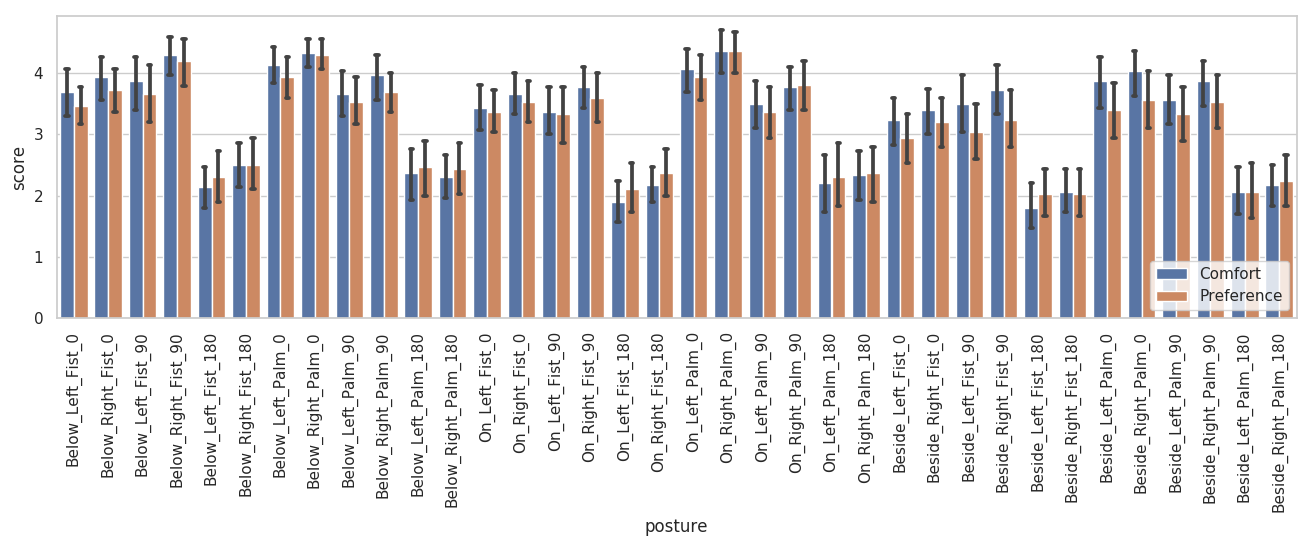

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x="posture", y="score", hue="rating", data=df_postures_stats, capsize=0.1)
ax.legend(loc='lower right')

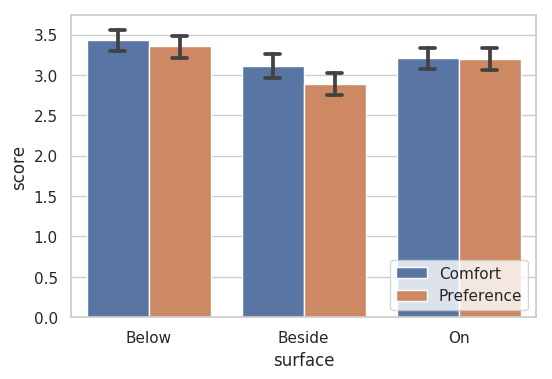

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="surface", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

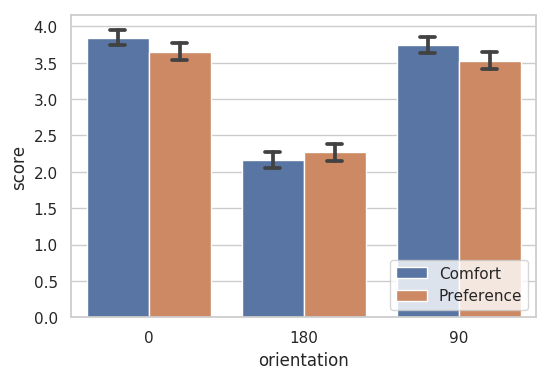

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="orientation", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

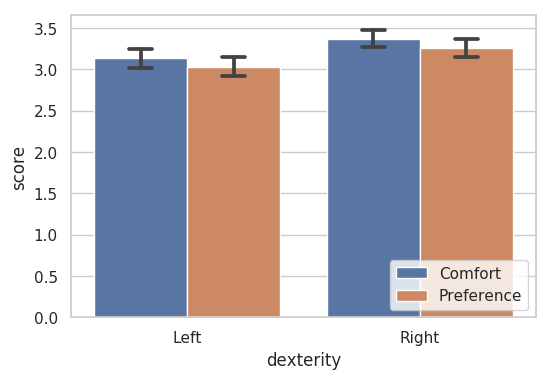

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="dexterity", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

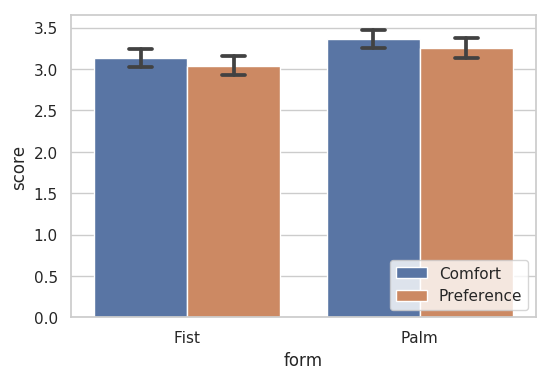

In [0]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
ax = sns.barplot(x="form", y="score", hue="rating", data=df_postures_stats_melted, capsize=0.1)
ax.legend(loc='lower right')

**To do**

- ~Compare postures across different dimensions (SURFACE, WRIST_ORIENTATION, HAND_FORM & DEXTERITY)~
- Give design recomendations based on above^^